<a href="https://colab.research.google.com/github/Bao-Truong/GCP_VisionAPI/blob/main/visionAPI_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import json
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math
import base64
from googleapiclient.discovery import build
import getpass
# APIKEY = getpass.getpass()
!pip install --upgrade google-api-python-client




Requirement already up-to-date: google-api-python-client in /usr/local/lib/python3.7/dist-packages (2.9.0)


In [15]:
def get_cord(info):
  cord_df=pd.DataFrame(info["boundingPoly"]["vertices"])
  x_min,y_min= np.min(cord_df["x"]), np.min(cord_df["y"])
  x_max,y_max= np.max(cord_df["x"]), np.max(cord_df["y"])
  return info["description"], x_max,x_min,y_max,y_min


filename="tanchayyee"
# filename="multiple_items"


-------------------------------------
Text Detection + Text Recognition
-------------------------------------

In [16]:
def encode_image(image):
  image_content = image.read()
  return base64.b64encode(image_content)

def isFile(dir):
    """
    Return True is dir is File else False
    """
    import os.path
    return os.path.isfile(dir)


def callVISIONAPI():
  responses={}
  json_response_file=f"{filename}_api.json"
  print(json_response_file)
  if(not isFile(json_response_file)):  # If The File Not exist, Call GOOGLE API
    print("CAlling API")
    with open(f"{filename}.jpg", "rb") as img_file:
      base64_img = encode_image(img_file)

    vservice = build('vision', 'v1', developerKey=APIKEY)
    request = vservice.images().annotate(body={
            'requests': [{
                    'image': {
                        'content':base64_img.decode("utf-8")                 
                    },
                    "features": [
                      {
                        "type":"DOCUMENT_TEXT_DETECTION",
                        "maxResults":1
                      }
                    ]
                }],
            })
    responses = request.execute(num_retries=0)
    print(responses)

    with open(f"{filename}_api.json","w+") as output_file:
      output_file.write(json.dumps(responses["responses"][0], indent=3))
    # print(responses)
  else:
    print("File Existed Dont need to Call VISION API")

callVISIONAPI()


tanchayyee_api.json
CAlling API
{'responses': [{'textAnnotations': [{'locale': 'en', 'description': 'tan chay yee\n*** COPY ***\nOJC MARKETING SDN BHD\nROC NO: 538358-H\nNO 2 & 4, JALAN BAYU 4,\nBANDAR SERI ALAM,\n81750 MASAI, JOHOR\nTel:07-388 2218 Fax:07-388 8218\nEmail: ng@ojcgroup.com\nTAX INVOICE\n...\nInvoice No : PEGIV-1030765\nDate\n: 15/01/2019 11:05:16 AM\nCashier : NG CHUAN MIN\nSales Persor: FATIN\nBill To : THE PEAK QUARRY WORKS\nAddress\nDescription\n000000111\nQty. Price Amount\n1 193.00 193.00 SR\nKINGS SAFETY SHOES KWD 805\nQty: 1\n193.00\nTotal Exclude GST:\nTotal GST 6%:\nTotal Inclusive GST:\nRound Amt:\nTOTAL:\nVISA CARD\nxxx.oooooocx4318\nApproval Code:000\n0.00\n193.00\n0.00\n193.00\n193.00\n(93.00\nGoods Sold Are Not Returnable & Refundable\n**** Thank You. Please Come Again.****\n', 'boundingPoly': {'vertices': [{'x': 15, 'y': 22}, {'x': 383, 'y': 22}, {'x': 383, 'y': 887}, {'x': 15, 'y': 887}]}}, {'description': 'tan', 'boundingPoly': {'vertices': [{'x': 105, 

---------------------------------------------------
Boxing Detected Text
---------------------------------------------------

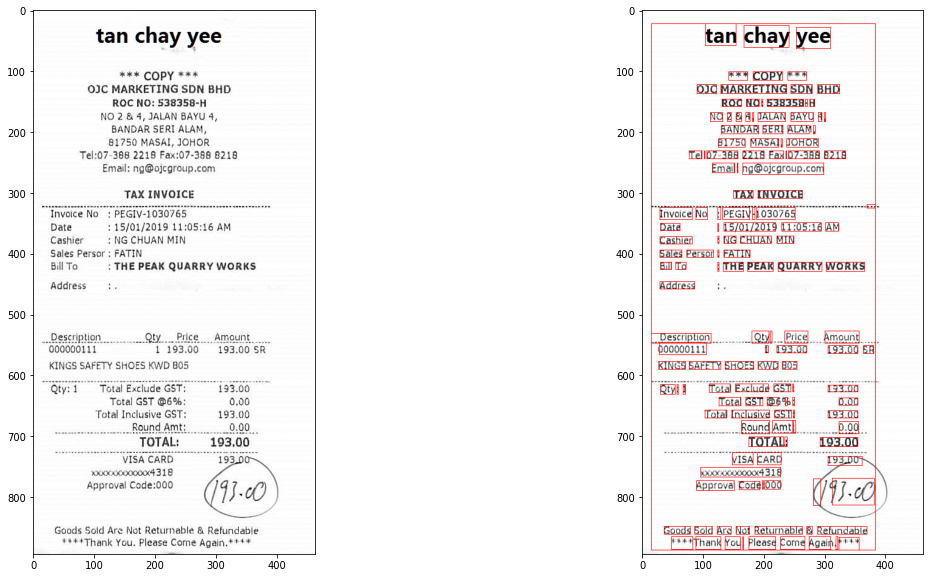

In [17]:

img2= cv.imread(f"./{filename}.jpg")
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img2)

with open(f"./{filename}_api.json") as file:
# with open("abc.json") as file:
  info= json.load(file)
textAnnos=info["textAnnotations"]
for textAnno in textAnnos:
  text, x_max,x_min,y_max,y_min=(get_cord(textAnno))
  img2= cv.rectangle(img2,(x_min,y_min),(x_max,y_max),(255,0,0),1)
cv.imwrite(f"{filename}_box.jpg",img2)
plt.subplot(122)
plt.imshow(img2)

EXTRACT INFORMATION BY ROW

------------------------------------------
Group All Text on Same Line Y-Axis With Threshold
------------------------------------------


In [22]:
ylocation={}
xlocation={}
threshold=10
img= img2
def group_by_y_index(ylocation,textAnnos,index,threshold=10):
  # Group by Same Line
  ylocation[index]=[]  
  distinct=" "
  textAnnos_copy=textAnnos.copy()[1:] # the first Paragraph is the whole image, so ignore it
  for info in textAnnos_copy.copy():
    cord_df=pd.DataFrame(info["boundingPoly"]["vertices"])
    x_min,y_min= np.min(cord_df["x"]), np.min(cord_df["y"])
    x_max,y_max= np.max(cord_df["x"]), np.max(cord_df["y"])
    # if(info["description"] in ["Exclude","193.00"]):
    #   print(y_min,index, info["description"])
    # if("Date"in info["description"] or "11/01/2019" in info["description"]):
      # print(info["description"], index, y_min)
      # input()
    if( index - threshold <= y_min <= index +threshold ):
      if(index not in xlocation): # Store The X Axis Location to rearrange the grouping Y Location later
        xlocation[index]={}
        xlocation[index][info["description"]]=x_min
      else:
        if(info["description"] in xlocation[index]):
          info["description"]=info["description"]+distinct
          distinct +=" "
        xlocation[index][info["description"]]=x_min
        
      ylocation[index].append(info["description"])
      # print("Going to index:",index,ylocation[index])
      textAnnos_copy.remove(info)
      # print(textAnnos)


for i in range(threshold, img.shape[0],2*threshold):
  group_by_y_index(ylocation,textAnnos,i,threshold)  


print("Group by Y Completed, Now Starting to Sort on X-Axis")

for index in range(threshold, img.shape[0],2*threshold):
  ylocation[index].sort(key=lambda x: xlocation[index].get(x,"0"))

for i,j in ylocation.copy().items():
  if(not j):
    ylocation.pop(i,None)
  else:
    print(i,j)


Group by Y Completed, Now Starting to Sort on X-Axis
30 ['tan', 'chay', 'yee']
110 ['***', 'COPY', '*** ']
130 ['OJC', 'MARKETING', 'SDN', 'BHD']
150 ['ROC', 'NO', ':', '538358', '-', 'H']
170 ['NO', '2', '&', '4', ',', 'JALAN', 'BAYU', '4 ', ',  ']
190 ['BANDAR', 'SERI', 'ALAM', ',']
210 ['81750', 'MASAI', ',', 'JOHOR']
230 ['Tel', ':', '07-388', '2218', 'Fax', ': ', '07-388  ', '8218']
250 ['Email', ':', 'ng@ojcgroup.com']
290 ['TAX', 'INVOICE']
310 ['...']
330 ['Invoice', 'No', ':', 'PEGIV', '-', '1030765']
350 ['Date', ':', '15/01/2019', '11:05:16', 'AM']
370 ['Cashier', ':', 'NG', 'CHUAN', 'MIN']
390 ['Sales', 'Persor', ':', 'FATIN']
410 ['Bill', 'To', ':', 'THE', 'PEAK', 'QUARRY', 'WORKS']
450 ['Address']
530 ['Description', 'Qty', '.', 'Price', 'Amount']
550 ['000000111', '1', '193.00', '193.00 ', 'SR']
570 ['KINGS', 'SAFETY', 'SHOES', 'KWD', '805']
610 ['Qty', ':', '1', 'Total', 'Exclude', 'GST', ': ', '193.00']
630 ['Total', 'GST', '6', '%', ':', '0.00']
650 ['Total', 'Inclusi

------------------------------------------
Keep it or Leave it
------------------------------------------

In [19]:

def checkValid(value, ftype):
    ftype = ftype.lower().strip()    
    if(value == None):  # if None is pass then use the default value
        return getDefault(ftype)
  
    if(ftype == "int"):
        def isInt(s):
            try:
                int(s)
                return True
            except ValueError:
                return False
        if(isInt(value)):
            return True
        return False
    if(ftype == "float"):
        def isFloat(s):
            try:
                float(s)
                return True
            except ValueError:
                return False
        if(isFloat(value)):
            return True
        return False
    if(ftype == "boolean" or ftype == "bool"):
        value = value.strip().lower()
        if value not in ["true", "false","1","0"]:
            return getDefault(ftype)
        if(value=="0"):
            return"false"
        if(value=="1"):
            return True
        return False
    if(ftype=="str"):
      return True
    return False
    
def takeOrLeave(item, item_type, missingVal):
  """
  Check for the item_type, if more than half of the item info is correct Type
  then accept to get that row info (dumb way without ML)
  Also filter the empty string item info
  """
  nof=len(item.keys())
  inc=0
  empty=0
  
  if(missingVal): # The Text Recognition step is missing some value, so only write output for the first column, wait for human handle
    for name,val in item.items():
      ftype=item_type.get(name,"str")
      if(checkValid(val,ftype)):
        inc+=1
      if(not val):
        empty+=1
      print("Should i use this infomation:",item.values(),item_type,inc, nof//2, inc>nof//2)
      if(inc==1):
        return True
      if(empty==1):
        return False
      return False
  
  for name,val in item.items():
    ftype=item_type.get(name,"str")
    if(checkValid(val,ftype)):
      inc+=1
    if(not val):
      empty+=1
  print("Should i use this infomation:",item.values(),item_type,inc, nof//2, inc>nof//2)

  if(nof == empty):
    return False
  if(inc==nof): #nof==1
    return True
  if(inc>nof//2): #if Correct Field is more than half
    return True
  return False

    

------------------------------------------
Information Extraction
------------------------------------------

In [20]:
setting=filename+".setting"
with open(f"./{setting}") as file:
  setting=json.load(file)
print(setting)
for a,b in ylocation.items():
  print(a,b)
output={}
################### GET ORDER DATE
def getDate(setting, ylocation):
  date_pattern=r'(0?[1-9]|[12][0-9]|3[01])\s?[/\.-]\s?(0[1-9]|1[012])\s?[/\.-]\s?(19|20)\d\d'
  result={}
  for orderdate in setting.get("orderdate",[]):
    field_name=orderdate.get("name","").strip().lower()
    if(field_name):# if have "name" value
      for index, vals in ylocation.items():
        val=[v.strip().lower() for v in vals]
        # print("field_name:",field_name,)
        for v in val:
          # if(field_name in [v.strip().lower() for v in vals]): # find for the "name" inside each line 
          if(field_name in v): # find for the "name" inside each line 
            for val in vals:
              # print(val)
              if(re.search(date_pattern,val)):
                # dates.append(val)
                result[field_name]=val

  # output["orderdate"]=dates
  return result

# dates=getDate(setting, ylocation)

#################### GET TOTAL
def getTotal(setting,ylocation):
  total_config= setting.get("total",{})
  result={}
  if(not total_config):
    return {}
  gettype= total_config.get("type",2)
  parts=total_config.get("parts",[])
  for part in parts:
    field_name=part.get("name","").strip().lower()
    field_name_no_space=field_name.replace(" ",'')
    location=part.get("location","last") # The Name may appear multiple time, but get the "last" value one 
    if(field_name):
      for index, val in ylocation.items():
        group_val= "".join(map(str,val)).lower().strip()
        
        if(field_name_no_space in group_val):
          # if(field_name not in result):
          if(gettype=="2"):
            result[field_name]=val[-1]
            if(location=="first"):
              break
  return result            

# for i in ylocation.values():
#   print(i)

#################### GET ITEMS
def getItems(setting, ylocation):
  result=[]
  items= setting.get("items",{})
  gettype=items.get("type","1")
  parts=items.get("parts",[])
  nof=len(parts) #Number of Field to get info

  default_item={}
  default_item_type={}
  default_item_order={}
  value_index={}
  for part in parts: ## CREATE THE DEFAULT_ITEM DICT (THE NUMBER OF FIELDS, STRUCTURE)
    field_name=part.get("name","")
    field_type=part.get("type","str")
    field_order=part.get("order")
    if(field_name):
      default_item[field_name]=""
      default_item_type[field_name]=field_type
      default_item_order[field_name]=field_order
    else:
      nof-=1
  # print(default_item)
  if(gettype=="1"): #Get the field from bellow and check the extract nof
    checkpoint=False #if meet the field_name then begin to look for item info on the NEXT lines
    for i, val in (ylocation.items()):
      index=-1
      inc=0
      if(checkpoint==True):
        item=default_item.copy()
        missingVal=False
        for i, field_name in enumerate(default_item.keys()): #Assign the Value
          if(len(val)>=nof and 0<=i<len(val) 
          and 0<=default_item_order[field_name]-1<=len(val)):
              # item[field_name]=val[i]       
              if(val[0]=="70549"):
                print("val:",val)   

              if(len(val) >= max(default_item_order.values())):  
                item[field_name]=val[default_item_order[field_name]-1].strip()
              else:
                if(i==0):
                  item[field_name]=val[0]       
                  missingVal=True
                # print("ERROR for this Items:",val)
              
        if(takeOrLeave(item,default_item_type,missingVal)): #Decide to get this Item Info or not
          result.append(item)          
        continue

      for field_name in default_item.keys():
        group_val="".join(map(str,val)).lower().strip().replace(" ",'')
        # print(field_name,[v.lower().strip() for v in val],group_val)
                   
        if(field_name in group_val ):
          inc+=1
        else:
           break
      # print("inc -nof:",inc, nof)
      if(inc==nof or inc >= math.floor(0.75 * nof)):
        print("Checkpoint to True")
        checkpoint=True
                                          
  return result


for name,value in setting.items():
  if(name=="orderdate"):
    output[name]=getDate(setting,ylocation)
  if(name=="total"):
    output[name]=getTotal(setting,ylocation)
  if(name=="items"):
    output[name]=getItems(setting,ylocation)
print(output)




{'orderdate': [{'name': 'date'}], 'items': {'type': '1', 'parts': [{'name': 'description', 'type': 'str', 'order': 1}, {'name': 'price', 'type': 'float', 'order': 3}, {'name': 'amount', 'type': 'float', 'order': 4}, {'name': 'qty', 'type': 'int', 'order': 2}]}, 'total': {'type': '2', 'parts': [{'name': 'total exclude gst', 'location': 'first'}, {'name': 'total', 'location': 'last'}]}}
27 ['tan', 'chay', 'yee']
99 ['***', 'COPY', '*** ']
117 ['OJC', 'MARKETING', 'SDN', 'BHD']
153 ['ROC', 'NO', ':', '538358', '-', 'H']
171 ['NO', '2', '&', '4', ',', 'JALAN', 'BAYU', '4 ', ',  ']
189 ['BANDAR', 'SERI', 'ALAM', ',']
207 ['81750', 'MASAI', ',', 'JOHOR']
225 ['Tel', ':', '07-388', '2218', 'Fax', ': ', '07-388  ', '8218']
243 ['Email', ':', 'ng@ojcgroup.com']
297 ['TAX', 'INVOICE']
315 ['Invoice', 'No', ':', 'PEGIV', '-', '1030765', '...']
333 ['Invoice', 'No', ':', 'PEGIV', '-', '1030765']
351 ['Date', ':', '15/01/2019', '11:05:16', 'AM']
369 ['Cashier', ':', 'NG', 'CHUAN', 'MIN']
387 ['Sale

------------------------------------------
Output Data To Json
------------------------------------------

In [21]:
with open(f"{filename}.output","w+") as file:
  file.write(json.dumps(output,indent=3))